# RL Controller Training and Testing
This notebook demonstrates the training and evaluation of an RL agent for microgrid control.

## Importing Libraries and Setup

In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Path setup
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
print("Using project_root:", project_root)

# Import simulation components
from microgrid_sim.core.gym_wrapper import MicrogridGymEnv
from microgrid_sim.control.rl_controller import RLController
from microgrid_sim.data import SyntheticDataBuilder
from microgrid_sim.utils import plot_simulation

print("Imports OK")

Using project_root: c:\Users\olanr\Downloads\course-proj\microgrid-control-sim
Imports OK


## Configuration

In [ ]:
# Training configuration
TOTAL_HOURS = 24 * 3  # 3 days
CONTROL_DT = 60  # Control every 60 minutes
SIM_DT = 5  # Physics at 1-minute resolution
SEED = 42

# Component sizing
BATTERY_CAPACITY_KWH = 50.0
BATTERY_MAX_CHARGE_KW = 8.0
BATTERY_MAX_DISCHARGE_KW = 8.0
DIESEL_MAX_KW = 15.0
PV_CAPACITY_KW = 5.0
WIND_CAPACITY_KW = 8.5
MAX_FACTORY_LOAD_KW = 15.0
MAX_RESIDENTIAL_LOAD_KW = 5.0

# Training parameters
TRAINING_TIMESTEPS = 10000  # Total training steps
EVAL_FREQ = 2000  # Evaluate every N steps
N_EVAL_EPISODES = 5

# Paths
MODEL_DIR = "./models"
LOG_DIR = "./logs/rl_training"
RESULTS_DIR = "./plots/05_rl_based_control"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Configuration complete.")

Configuration complete.


## Data Generation

In [3]:
# Create synthetic data builder
data_builder_train = SyntheticDataBuilder(
    total_hours=TOTAL_HOURS,
    sim_dt_minutes=SIM_DT,
    seed=SEED
)

# Add components to data builder
data_builder_train.add_pv("pv", peak_irr=900)
data_builder_train.add_wind("wind", mean_speed=6.0)
data_builder_train.add_load("factory", base_kw=10.0, profile="factory")
data_builder_train.add_load("house", base_kw=3.0, profile="residential")
data_builder_train.add_grid_prices("grid")

print("Training data builder configured.")

# Create evaluation data builder (different seed)
data_builder_eval = SyntheticDataBuilder(
    total_hours=TOTAL_HOURS,
    sim_dt_minutes=SIM_DT,
    seed=SEED + 100
)

data_builder_eval.add_pv("pv", peak_irr=900)
data_builder_eval.add_wind("wind", mean_speed=6.0)
data_builder_eval.add_load("factory", base_kw=10.0, profile="factory")
data_builder_eval.add_load("house", base_kw=3.0, profile="residential")
data_builder_eval.add_grid_prices("grid")

print("Evaluation data builder configured.")

Training data builder configured.
Evaluation data builder configured.


## Create Gym Environments

In [4]:
# Training environment
train_env = MicrogridGymEnv(
    data_builder=data_builder_train,
    simulation_hours=TOTAL_HOURS,
    control_interval_minutes=CONTROL_DT,
    sim_dt_minutes=SIM_DT,
    battery_capacity_kwh=BATTERY_CAPACITY_KWH,
    battery_max_charge_kw=BATTERY_MAX_CHARGE_KW,
    battery_max_discharge_kw=BATTERY_MAX_DISCHARGE_KW,
    diesel_max_kw=DIESEL_MAX_KW,
    pv_capacity_kw=PV_CAPACITY_KW,
    wind_capacity_kw=WIND_CAPACITY_KW,
    max_factory_load_kw=MAX_FACTORY_LOAD_KW,
    max_residential_load_kw=MAX_RESIDENTIAL_LOAD_KW,
    reward_weights={
        "cost": -1.0,
        "unmet": -100.0,  # Heavily penalize unmet load
        "curtailment": -0.5,
        "soc_deviation": -1.0
    }
)

# Evaluation environment
eval_env = MicrogridGymEnv(
    data_builder=data_builder_eval,
    simulation_hours=TOTAL_HOURS,
    control_interval_minutes=CONTROL_DT,
    sim_dt_minutes=SIM_DT,
    battery_capacity_kwh=BATTERY_CAPACITY_KWH,
    battery_max_charge_kw=BATTERY_MAX_CHARGE_KW,
    battery_max_discharge_kw=BATTERY_MAX_DISCHARGE_KW,
    diesel_max_kw=DIESEL_MAX_KW,
    pv_capacity_kw=PV_CAPACITY_KW,
    wind_capacity_kw=WIND_CAPACITY_KW,
    max_factory_load_kw=MAX_FACTORY_LOAD_KW,
    max_residential_load_kw=MAX_RESIDENTIAL_LOAD_KW
)

print("Gym environments created.")

Gym environments created.


## Test Random Policy (Baseline)


=== Testing Random Policy (Baseline) ===
Random Policy Total Reward: -14300.64
Random Policy Total Cost: $-107.73
Random policy baseline complete.



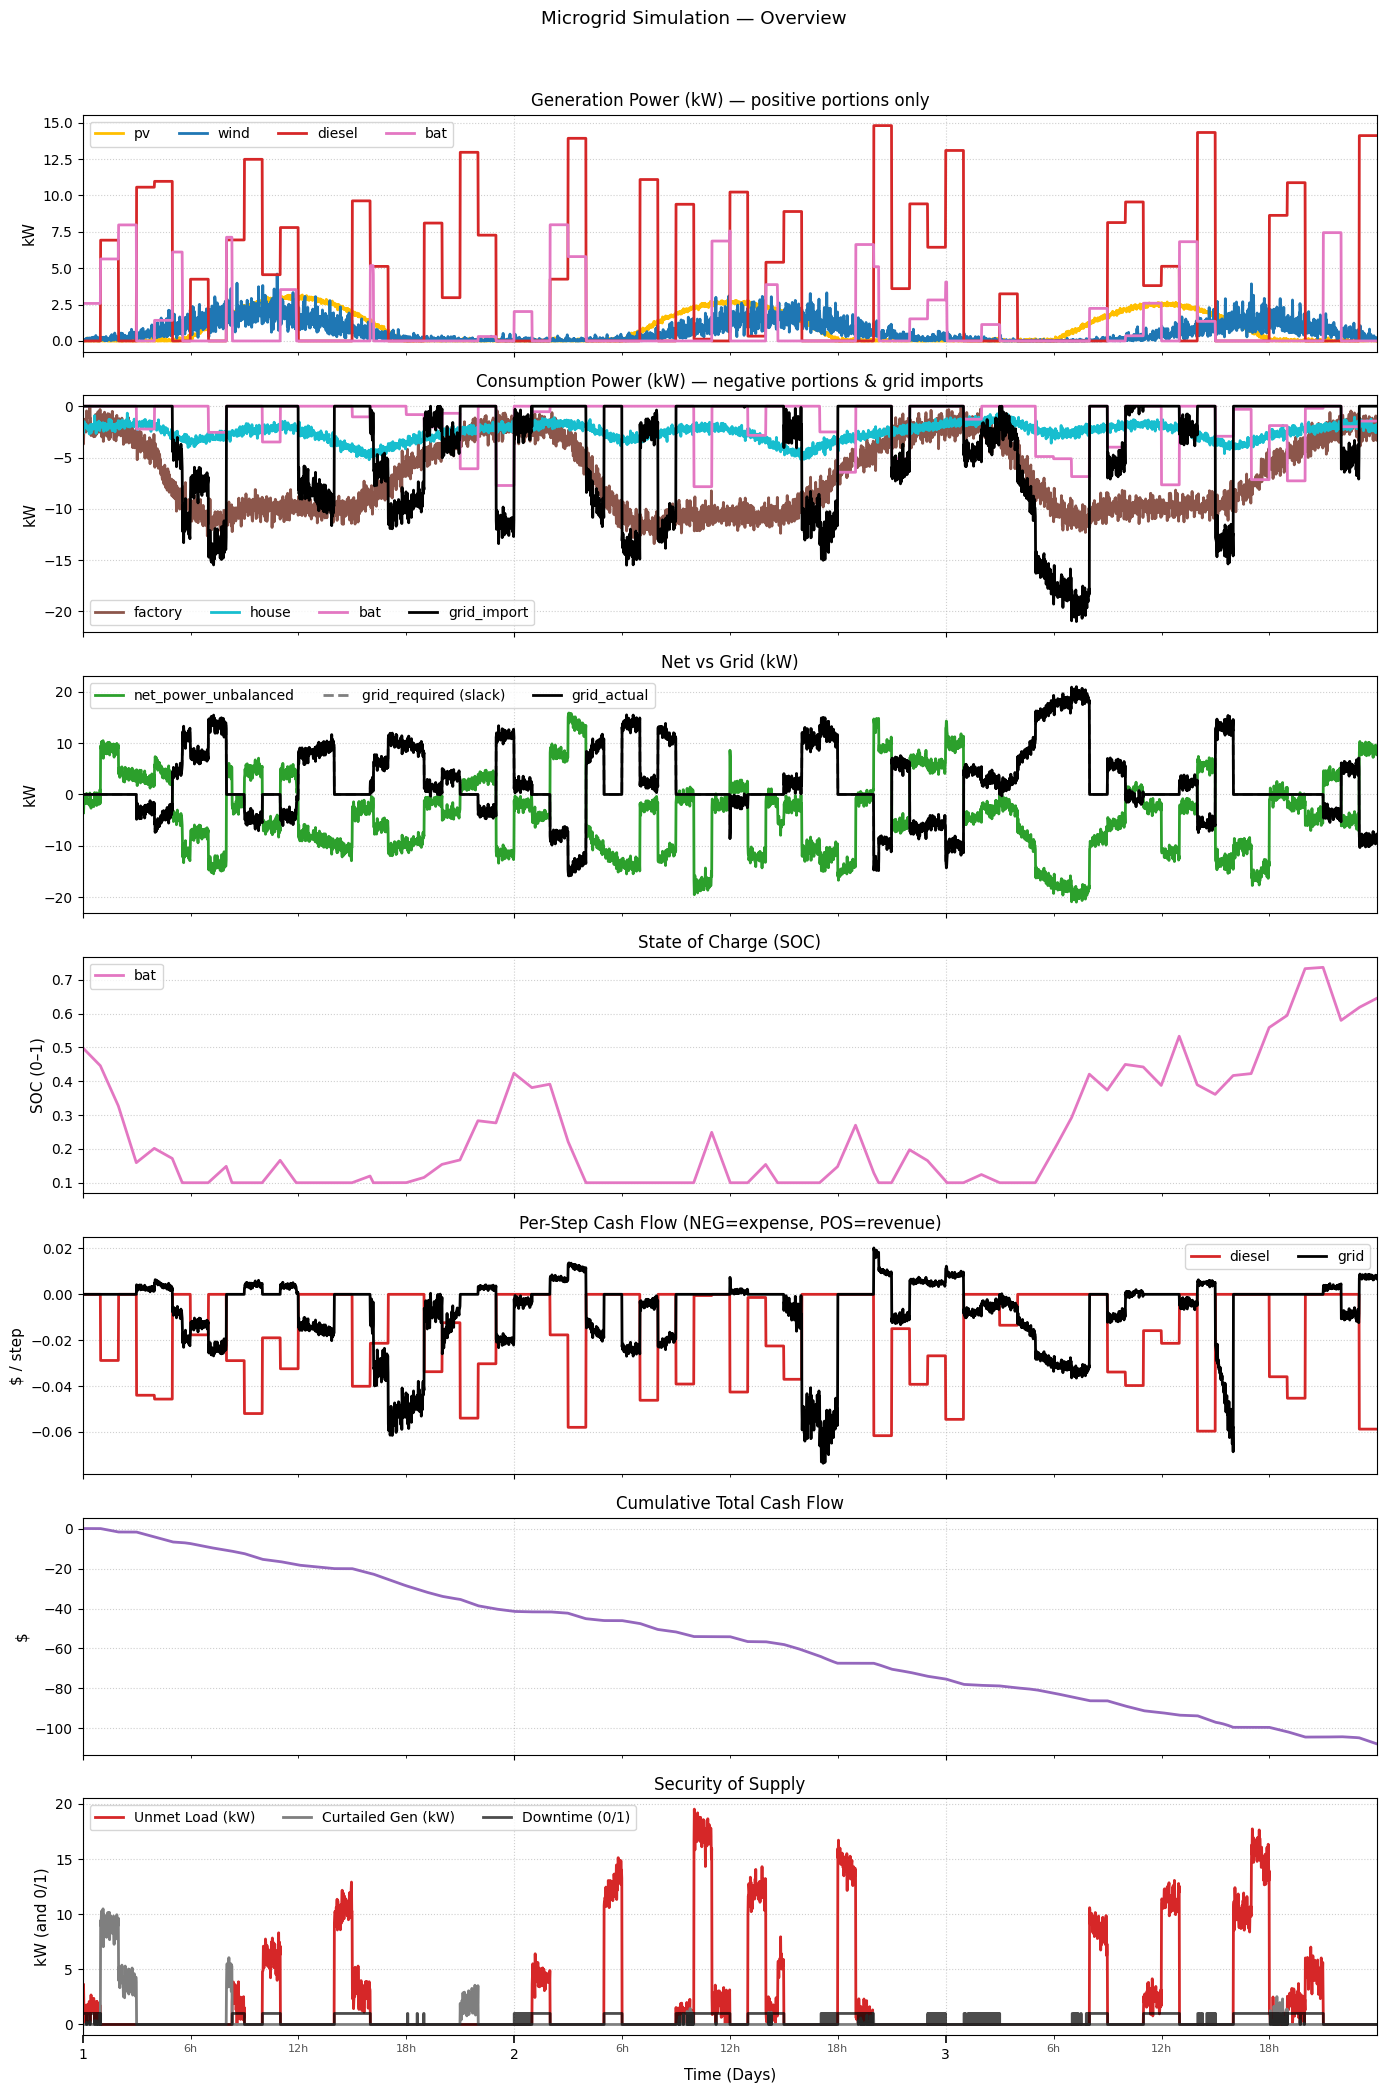

In [5]:
print("\n=== Testing Random Policy (Baseline) ===")

obs, info = train_env.reset(seed=SEED)
episode_reward = 0.0
done = False

while not done:
    # Sample random action
    action = train_env.action_space.sample()
    obs, reward, terminated, truncated, info = train_env.step(action)
    done = terminated or truncated
    episode_reward += reward

print(f"Random Policy Total Reward: {episode_reward:.2f}")
print(f"Random Policy Total Cost: ${info['total_cost']:.2f}")

# Get results and plot
df_random = train_env.env.get_results(as_dataframe=True)
_ = plot_simulation(
    df_random,
    sim_dt_minutes=SIM_DT,
    sim_name="05-01_random_policy",
    save=True,
    base_dir=RESULTS_DIR
)

print("Random policy baseline complete.\n")

## Train RL Agent

In [6]:
print("\n=== Training RL Agent ===")

# Initialize controller
rl_controller = RLController(
    env=train_env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    verbose=1
)

# Train the agent
rl_controller.train(
    total_timesteps=TRAINING_TIMESTEPS,
    log_dir=LOG_DIR,
    eval_env=eval_env,
    eval_freq=EVAL_FREQ,
    n_eval_episodes=N_EVAL_EPISODES
)

# Save the trained model
model_path = os.path.join(MODEL_DIR, "ppo_microgrid")
rl_controller.save(model_path)

print(f"\nModel saved to {model_path}.zip")


=== Training RL Agent ===
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PPO model initialized with hyperparameters:
  policy: MlpPolicy
  learning_rate: 0.0003
  n_steps: 2048
  batch_size: 64
  n_epochs: 10
  gamma: 0.99
  gae_lambda: 0.95
  clip_range: 0.2
  ent_coef: 0.01
  vf_coef: 0.5
  max_grad_norm: 0.5
  device: auto
Logging to ./logs/rl_training


Output()


Starting training for 50000 timesteps...


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 72        |
|    ep_rew_mean     | -2.37e+04 |
| time/              |           |
|    fps             | 41        |
|    iterations      | 1         |
|    time_elapsed    | 49        |
|    total_timesteps | 2048      |
----------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 72          |
|    ep_rew_mean          | -2.15e+04   |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 2           |
|    time_elapsed         | 105         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.002639063 |
|    clip_fraction        | 0.00137     |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.4       |
|    explained_variance   | 9.06e-06    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.5e+07     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00544    |
|    std                  | 1           |
|    value_loss           | 2.38e+07    |
-----------------------------------------


c:\Users\olanr\miniconda3\envs\microgrid-sim\lib\site-packages\stable_baselines3\common\evaluation.py:70: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=5000, episode_reward=79.11 +/- 3.93

Episode length: 72.00 +/- 0.00

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 72            |
|    mean_reward          | 79.1          |
| time/                   |               |
|    total_timesteps      | 5000          |
| train/                  |               |
|    approx_kl            | 0.00095073564 |
|    clip_fraction        | 4.88e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -11.4         |
|    explained_variance   | -4.61e-05     |
|    learning_rate        | 0.0003        |
|    loss                 | 7.67e+06      |
|    n_updates            | 20            |
|    policy_gradient_loss | -0.00262      |
|    std                  | 1             |
|    value_loss           | 1.65e+07      |
-------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 72       |
|    ep_rew_mean     | -2.1e+04 |
| time/              |          |
|    fps             | 34       |
|    iterations      | 3        |
|    time_elapsed    | 176      |
|    total_timesteps | 6144     |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 72           |
|    ep_rew_mean          | -2.01e+04    |
| time/                   |              |
|    fps                  | 34           |
|    iterations           | 4            |
|    time_elapsed         | 240          |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0013870228 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.4        |
|    explained_variance   | -2.57e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 8.01e+06     |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00325     |
|    std                  | 1            |
|    value_loss           | 1.77e+07     |
------------------------------------------


Eval num_timesteps=10000, episode_reward=79.15 +/- 2.02

Episode length: 72.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 72          |
|    mean_reward          | 79.2        |
| time/                   |             |
|    total_timesteps      | 10000       |
| train/                  |             |
|    approx_kl            | 0.001514432 |
|    clip_fraction        | 0.000391    |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.4       |
|    explained_variance   | -6.44e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | 6.66e+06    |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00412    |
|    std                  | 1           |
|    value_loss           | 1.59e+07    |
-----------------------------------------


New best mean reward!

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 72        |
|    ep_rew_mean     | -1.93e+04 |
| time/              |           |
|    fps             | 35        |
|    iterations      | 5         |
|    time_elapsed    | 291       |
|    total_timesteps | 10240     |
----------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 72           |
|    ep_rew_mean          | -1.87e+04    |
| time/                   |              |
|    fps                  | 36           |
|    iterations           | 6            |
|    time_elapsed         | 334          |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 0.0035890671 |
|    clip_fraction        | 0.00669      |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.4        |
|    explained_variance   | -2.15e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 6.9e+06      |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00794     |
|    std                  | 1            |
|    value_loss           | 1.48e+07     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 72           |
|    ep_rew_mean          | -1.75e+04    |
| time/                   |              |
|    fps                  | 35           |
|    iterations           | 7            |
|    time_elapsed         | 400          |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0037251296 |
|    clip_fraction        | 0.00522      |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.4        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 7.34e+06     |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00774     |
|    std                  | 1            |
|    value_loss           | 1.47e+07     |
------------------------------------------


c:\Users\olanr\miniconda3\envs\microgrid-sim\lib\site-packages\stable_baselines3\common\evaluation.py:70: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=15000, episode_reward=74.00 +/- 4.84

Episode length: 72.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 72           |
|    mean_reward          | 74           |
| time/                   |              |
|    total_timesteps      | 15000        |
| train/                  |              |
|    approx_kl            | 0.0036862171 |
|    clip_fraction        | 0.00562      |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.3        |
|    explained_variance   | 2.98e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 5.53e+06     |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.00635     |
|    std                  | 1            |
|    value_loss           | 1.13e+07     |
------------------------------------------


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 72        |
|    ep_rew_mean     | -1.61e+04 |
| time/              |           |
|    fps             | 34        |
|    iterations      | 8         |
|    time_elapsed    | 470       |
|    total_timesteps | 16384     |
----------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 72           |
|    ep_rew_mean          | -1.49e+04    |
| time/                   |              |
|    fps                  | 34           |
|    iterations           | 9            |
|    time_elapsed         | 535          |
|    total_timesteps      | 18432        |
| train/                  |              |
|    approx_kl            | 0.0024288485 |
|    clip_fraction        | 0.00181      |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.3        |
|    explained_variance   | -2.38e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 4.3e+06      |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00478     |
|    std                  | 1            |
|    value_loss           | 9.97e+06     |
------------------------------------------


c:\Users\olanr\miniconda3\envs\microgrid-sim\lib\site-packages\stable_baselines3\common\evaluation.py:70: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=20000, episode_reward=73.37 +/- 4.12

Episode length: 72.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 72           |
|    mean_reward          | 73.4         |
| time/                   |              |
|    total_timesteps      | 20000        |
| train/                  |              |
|    approx_kl            | 0.0041608186 |
|    clip_fraction        | 0.00967      |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.3        |
|    explained_variance   | -2.03e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 4.3e+06      |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00746     |
|    std                  | 1            |
|    value_loss           | 9.42e+06     |
------------------------------------------


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 72        |
|    ep_rew_mean     | -1.32e+04 |
| time/              |           |
|    fps             | 33        |
|    iterations      | 10        |
|    time_elapsed    | 610       |
|    total_timesteps | 20480     |
----------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 72         |
|    ep_rew_mean          | -1.21e+04  |
| time/                   |            |
|    fps                  | 33         |
|    iterations           | 11         |
|    time_elapsed         | 669        |
|    total_timesteps      | 22528      |
| train/                  |            |
|    approx_kl            | 0.00596641 |
|    clip_fraction        | 0.0225     |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.3      |
|    explained_variance   | 1.79e-07   |
|    learning_rate        | 0.0003     |
|    loss                 | 4.64e+06   |
|    n_updates            | 100        |
|    policy_gradient_loss | -0.00829   |
|    std                  | 1          |
|    value_loss           | 6.97e+06   |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 72           |
|    ep_rew_mean          | -1.11e+04    |
| time/                   |              |
|    fps                  | 33           |
|    iterations           | 12           |
|    time_elapsed         | 728          |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0046996037 |
|    clip_fraction        | 0.0141       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.4        |
|    explained_variance   | -1.91e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 3.16e+06     |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00752     |
|    std                  | 1            |
|    value_loss           | 6.57e+06     |
------------------------------------------


c:\Users\olanr\miniconda3\envs\microgrid-sim\lib\site-packages\stable_baselines3\common\evaluation.py:70: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=25000, episode_reward=73.58 +/- 5.18

Episode length: 72.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 72           |
|    mean_reward          | 73.6         |
| time/                   |              |
|    total_timesteps      | 25000        |
| train/                  |              |
|    approx_kl            | 0.0053826016 |
|    clip_fraction        | 0.0212       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.3        |
|    explained_variance   | 3.58e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 2.54e+06     |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.009       |
|    std                  | 1            |
|    value_loss           | 5.29e+06     |
------------------------------------------


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 72        |
|    ep_rew_mean     | -1.01e+04 |
| time/              |           |
|    fps             | 32        |
|    iterations      | 13        |
|    time_elapsed    | 810       |
|    total_timesteps | 26624     |
----------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 72           |
|    ep_rew_mean          | -9.23e+03    |
| time/                   |              |
|    fps                  | 32           |
|    iterations           | 14           |
|    time_elapsed         | 874          |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0048660166 |
|    clip_fraction        | 0.0131       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.3        |
|    explained_variance   | -3.58e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.7e+06      |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.00655     |
|    std                  | 1            |
|    value_loss           | 5.49e+06     |
------------------------------------------


c:\Users\olanr\miniconda3\envs\microgrid-sim\lib\site-packages\stable_baselines3\common\evaluation.py:70: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=30000, episode_reward=73.96 +/- 5.71

Episode length: 72.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 72           |
|    mean_reward          | 74           |
| time/                   |              |
|    total_timesteps      | 30000        |
| train/                  |              |
|    approx_kl            | 0.0063105887 |
|    clip_fraction        | 0.0346       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.3        |
|    explained_variance   | -3.58e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.25e+06     |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00857     |
|    std                  | 1            |
|    value_loss           | 4.64e+06     |
------------------------------------------


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 72        |
|    ep_rew_mean     | -8.36e+03 |
| time/              |           |
|    fps             | 32        |
|    iterations      | 15        |
|    time_elapsed    | 942       |
|    total_timesteps | 30720     |
----------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 72          |
|    ep_rew_mean          | -7.12e+03   |
| time/                   |             |
|    fps                  | 32          |
|    iterations           | 16          |
|    time_elapsed         | 999         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.003314831 |
|    clip_fraction        | 0.0106      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.3       |
|    explained_variance   | -7.15e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.38e+06    |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00473    |
|    std                  | 1           |
|    value_loss           | 3.2e+06     |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 72           |
|    ep_rew_mean          | -5.9e+03     |
| time/                   |              |
|    fps                  | 32           |
|    iterations           | 17           |
|    time_elapsed         | 1064         |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0041938936 |
|    clip_fraction        | 0.0127       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.3        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.2e+06      |
|    n_updates            | 160          |
|    policy_gradient_loss | -0.0057      |
|    std                  | 1            |
|    value_loss           | 3.21e+06     |
------------------------------------------


Eval num_timesteps=35000, episode_reward=79.99 +/- 1.78

Episode length: 72.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 72         |
|    mean_reward          | 80         |
| time/                   |            |
|    total_timesteps      | 35000      |
| train/                  |            |
|    approx_kl            | 0.00538068 |
|    clip_fraction        | 0.0396     |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.3      |
|    explained_variance   | -4.77e-07  |
|    learning_rate        | 0.0003     |
|    loss                 | 8.68e+05   |
|    n_updates            | 170        |
|    policy_gradient_loss | -0.00722   |
|    std                  | 0.996      |
|    value_loss           | 2.04e+06   |
----------------------------------------


New best mean reward!

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 72        |
|    ep_rew_mean     | -4.65e+03 |
| time/              |           |
|    fps             | 32        |
|    iterations      | 18        |
|    time_elapsed    | 1139      |
|    total_timesteps | 36864     |
----------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 72          |
|    ep_rew_mean          | -4.06e+03   |
| time/                   |             |
|    fps                  | 32          |
|    iterations           | 19          |
|    time_elapsed         | 1192        |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.006066651 |
|    clip_fraction        | 0.0432      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.3       |
|    explained_variance   | -2.38e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 3.99e+05    |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.009      |
|    std                  | 0.999       |
|    value_loss           | 1.32e+06    |
-----------------------------------------


c:\Users\olanr\miniconda3\envs\microgrid-sim\lib\site-packages\stable_baselines3\common\evaluation.py:70: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=40000, episode_reward=75.75 +/- 8.56

Episode length: 72.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 72          |
|    mean_reward          | 75.8        |
| time/                   |             |
|    total_timesteps      | 40000       |
| train/                  |             |
|    approx_kl            | 0.003969459 |
|    clip_fraction        | 0.0183      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.3       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.01e+06    |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00672    |
|    std                  | 1           |
|    value_loss           | 1.82e+06    |
-----------------------------------------


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 72        |
|    ep_rew_mean     | -3.81e+03 |
| time/              |           |
|    fps             | 32        |
|    iterations      | 20        |
|    time_elapsed    | 1252      |
|    total_timesteps | 40960     |
----------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 72           |
|    ep_rew_mean          | -3.27e+03    |
| time/                   |              |
|    fps                  | 32           |
|    iterations           | 21           |
|    time_elapsed         | 1306         |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0057909135 |
|    clip_fraction        | 0.0263       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.3        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.78e+06     |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.00529     |
|    std                  | 1            |
|    value_loss           | 2.78e+06     |
------------------------------------------


c:\Users\olanr\miniconda3\envs\microgrid-sim\lib\site-packages\stable_baselines3\common\evaluation.py:70: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=45000, episode_reward=77.38 +/- 7.26

Episode length: 72.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 72           |
|    mean_reward          | 77.4         |
| time/                   |              |
|    total_timesteps      | 45000        |
| train/                  |              |
|    approx_kl            | 0.0076876557 |
|    clip_fraction        | 0.0539       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.3        |
|    explained_variance   | -2.38e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 5.52e+05     |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.008       |
|    std                  | 0.995        |
|    value_loss           | 1.55e+06     |
------------------------------------------


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 72        |
|    ep_rew_mean     | -2.83e+03 |
| time/              |           |
|    fps             | 33        |
|    iterations      | 22        |
|    time_elapsed    | 1364      |
|    total_timesteps | 45056     |
----------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 72          |
|    ep_rew_mean          | -2.57e+03   |
| time/                   |             |
|    fps                  | 33          |
|    iterations           | 23          |
|    time_elapsed         | 1408        |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.004056751 |
|    clip_fraction        | 0.0279      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.2       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 7.83e+05    |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00581    |
|    std                  | 0.994       |
|    value_loss           | 1.55e+06    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 72          |
|    ep_rew_mean          | -2.44e+03   |
| time/                   |             |
|    fps                  | 33          |
|    iterations           | 24          |
|    time_elapsed         | 1446        |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.006257306 |
|    clip_fraction        | 0.036       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.2       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 8.89e+05    |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00593    |
|    std                  | 0.992       |
|    value_loss           | 2.15e+06    |
-----------------------------------------


c:\Users\olanr\miniconda3\envs\microgrid-sim\lib\site-packages\stable_baselines3\common\evaluation.py:70: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=50000, episode_reward=77.88 +/- 4.84

Episode length: 72.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 72          |
|    mean_reward          | 77.9        |
| time/                   |             |
|    total_timesteps      | 50000       |
| train/                  |             |
|    approx_kl            | 0.005952059 |
|    clip_fraction        | 0.0284      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.2       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 8.92e+05    |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00713    |
|    std                  | 0.995       |
|    value_loss           | 1.64e+06    |
-----------------------------------------


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 72        |
|    ep_rew_mean     | -2.34e+03 |
| time/              |           |
|    fps             | 34        |
|    iterations      | 25        |
|    time_elapsed    | 1491      |
|    total_timesteps | 51200     |
----------------------------------


Training complete!
Model saved to ./models\ppo_microgrid.zip

Model saved to ./models\ppo_microgrid.zip


## Evaluate Trained RL Agent


=== Evaluating Trained RL Agent ===
RL Policy Total Reward: 74.61
RL Policy Total Cost: $-82.73
Episode Length: 72 steps
RL policy evaluation complete.



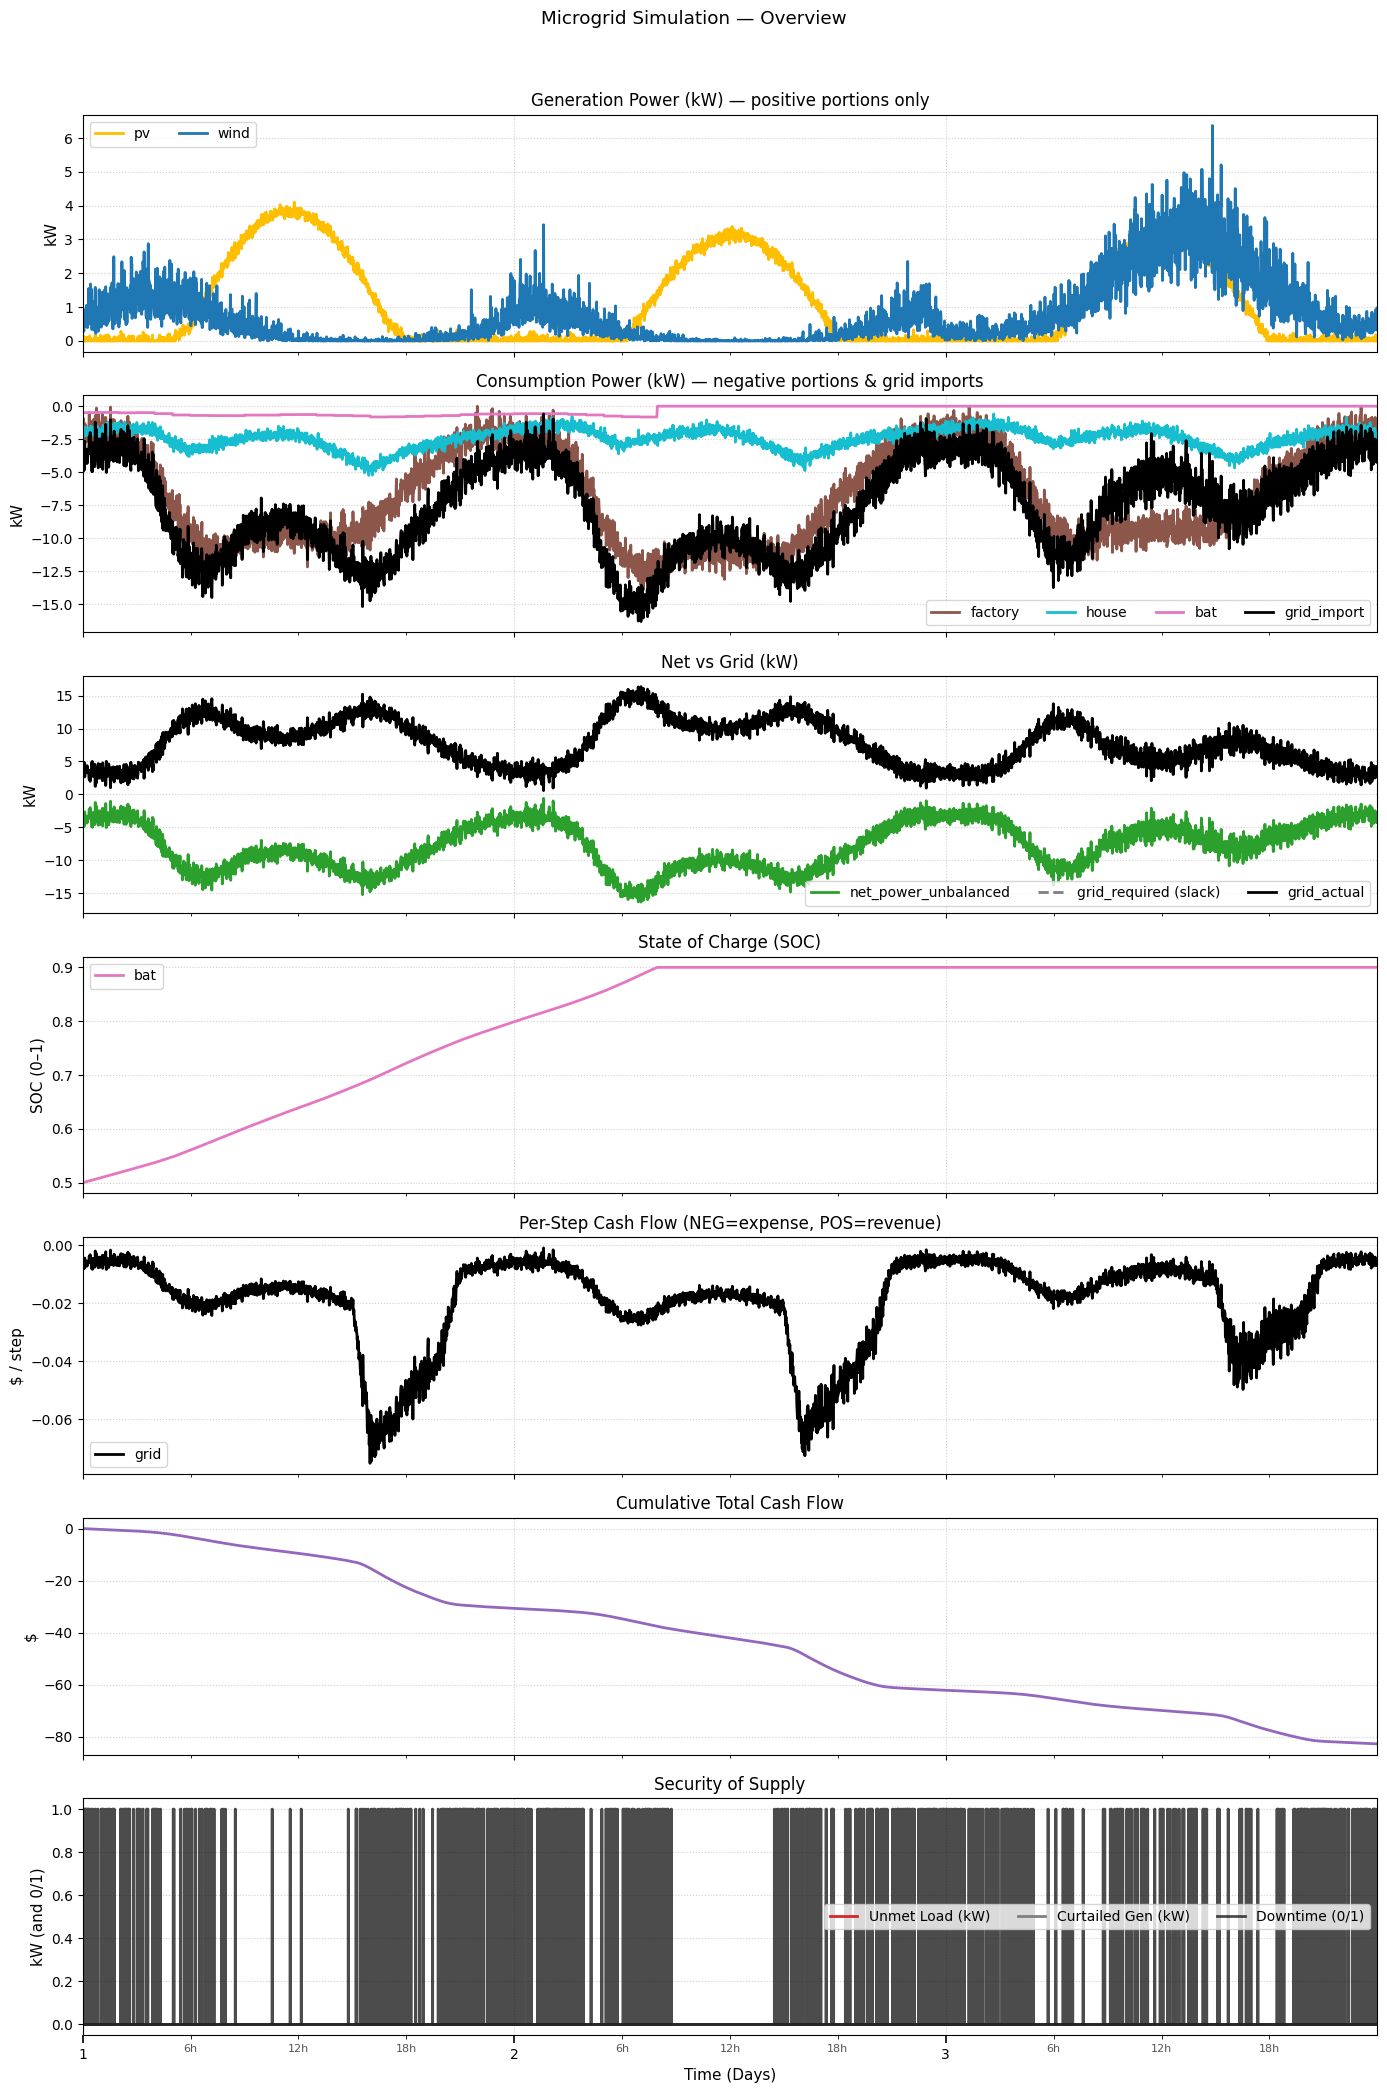

In [7]:
print("\n=== Evaluating Trained RL Agent ===")

# Reset environment
obs, info = train_env.reset(seed=SEED)
episode_reward = 0.0
done = False
step_count = 0

while not done:
    # Get action from trained policy
    action = rl_controller.decide(obs, deterministic=True)
    obs, reward, terminated, truncated, info = train_env.step(action)
    done = terminated or truncated
    episode_reward += reward
    step_count += 1

print(f"RL Policy Total Reward: {episode_reward:.2f}")
print(f"RL Policy Total Cost: ${info['total_cost']:.2f}")
print(f"Episode Length: {step_count} steps")

# Get results and plot
df_rl = train_env.env.get_results(as_dataframe=True)
_ = plot_simulation(
    df_rl,
    sim_dt_minutes=SIM_DT,
    sim_name="05-02_rl_policy",
    save=True,
    base_dir=RESULTS_DIR
)

print("RL policy evaluation complete.\n")

## Compare Performance

In [8]:
print("\n=== Performance Comparison ===")

# Calculate metrics for random policy
dt_hours = SIM_DT / 60.0
random_unmet = df_random["unmet_load_kw"].sum() * dt_hours
random_curtailed = df_random["curtailed_gen_kw"].sum() * dt_hours
random_cost = df_random["total_cashflow"].sum()

# Calculate metrics for RL policy
rl_unmet = df_rl["unmet_load_kw"].sum() * dt_hours
rl_curtailed = df_rl["curtailed_gen_kw"].sum() * dt_hours
rl_cost = df_rl["total_cashflow"].sum()

# Create comparison table
comparison = pd.DataFrame({
    "Metric": ["Total Cost ($)", "Unmet Energy (kWh)", "Curtailed Energy (kWh)"],
    "Random Policy": [random_cost, random_unmet, random_curtailed],
    "RL Policy": [rl_cost, rl_unmet, rl_curtailed],
    "Improvement (%)": [
        100 * (random_cost - rl_cost) / abs(random_cost) if random_cost != 0 else 0,
        100 * (random_unmet - rl_unmet) / random_unmet if random_unmet > 0 else 0,
        100 * (random_curtailed - rl_curtailed) / random_curtailed if random_curtailed > 0 else 0
    ]
})

print(comparison.to_string(index=False))


=== Performance Comparison ===
                Metric  Random Policy     RL Policy  Improvement (%)
        Total Cost ($)    -107.728847 -8.273483e+01       -23.200854
    Unmet Energy (kWh)     143.928819  1.064704e-14       100.000000
Curtailed Energy (kWh)      16.951148  1.079137e-14       100.000000


## Load and Test Saved Model

In [9]:
print("\n=== Testing Model Loading ===")

# Load the saved model
loaded_controller = RLController.load(
    path=model_path,
    env=eval_env,
    verbose=1
)

# Evaluate loaded model
mean_reward, std_reward = loaded_controller.evaluate(
    env=eval_env,
    n_episodes=3,
    deterministic=True
)

print(f"\nLoaded Model Performance:")
print(f"  Mean Reward: {mean_reward:.2f} +/- {std_reward:.2f}")


=== Testing Model Loading ===
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PPO model initialized with hyperparameters:
  policy: MlpPolicy
  learning_rate: 0.0003
  n_steps: 2048
  batch_size: 64
  n_epochs: 10
  gamma: 0.99
  gae_lambda: 0.95
  clip_range: 0.2
  ent_coef: 0.01
  vf_coef: 0.5
  max_grad_norm: 0.5
  device: auto
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Model loaded from ./models\ppo_microgrid.zip
Episode 1/3: Reward = 84.53
Episode 2/3: Reward = 72.40
Episode 3/3: Reward = 83.95

Evaluation Results (3 episodes):
  Mean Reward: 80.29 +/- 5.58

Loaded Model Performance:
  Mean Reward: 80.29 +/- 5.58


## Multi-Episode Evaluation

In [10]:
print("\n=== Multi-Episode Evaluation ===")

n_test_episodes = 5
episode_results = []

for ep in range(n_test_episodes):
    obs, info = eval_env.reset(seed=SEED + ep)
    episode_reward = 0.0
    episode_cost = 0.0
    done = False

    while not done:
        action = loaded_controller.decide(obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_cost = info['total_cost']

    episode_results.append({
        "Episode": ep + 1,
        "Reward": episode_reward,
        "Cost": episode_cost
    })

    print(f"Episode {ep+1}: Reward={episode_reward:.2f}, Cost=${episode_cost:.2f}")

results_df = pd.DataFrame(episode_results)
print("\nSummary Statistics:")
print(results_df.describe())


=== Multi-Episode Evaluation ===
Episode 1: Reward=73.67, Cost=$-77.69
Episode 2: Reward=82.54, Cost=$-86.58
Episode 3: Reward=69.91, Cost=$-73.91
Episode 4: Reward=81.93, Cost=$-86.00
Episode 5: Reward=74.49, Cost=$-78.56

Summary Statistics:
        Episode     Reward       Cost
count  5.000000   5.000000   5.000000
mean   3.000000  76.508438 -80.549819
std    1.581139   5.508965   5.529321
min    1.000000  69.912473 -86.582258
25%    2.000000  73.674276 -86.001498
50%    3.000000  74.486007 -78.562917
75%    4.000000  81.930751 -77.690137
max    5.000000  82.538682 -73.912284


## Visualize Action Distribution


=== Analyzing Action Distribution ===


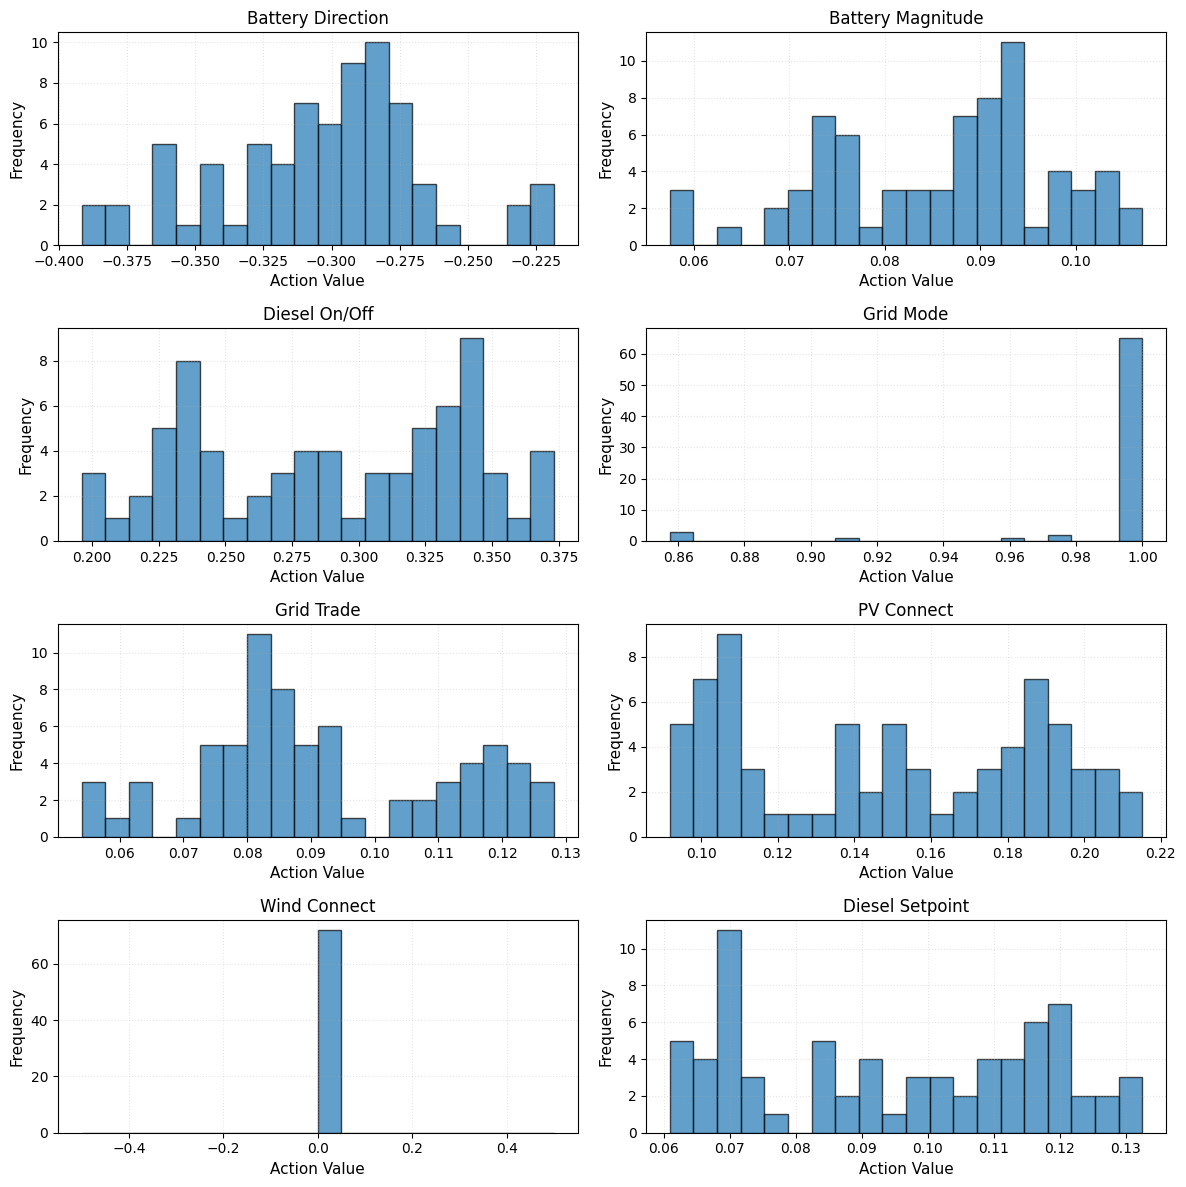

Action distribution analysis complete.


In [11]:
print("\n=== Analyzing Action Distribution ===")

# Run one episode and collect actions
obs, _ = train_env.reset(seed=SEED)
done = False
actions_collected = []

while not done:
    action = rl_controller.decide(obs, deterministic=True)
    actions_collected.append(action)
    obs, reward, terminated, truncated, info = train_env.step(action)
    done = terminated or truncated

actions_array = np.array(actions_collected)

# Plot action distributions
fig, axes = plt.subplots(4, 2, figsize=(12, 12))
action_names = [
    "Battery Direction", "Battery Magnitude", "Diesel On/Off", "Grid Mode",
    "Grid Trade", "PV Connect", "Wind Connect", "Diesel Setpoint"
]

for i, (ax, name) in enumerate(zip(axes.flat, action_names)):
    ax.hist(actions_array[:, i], bins=20, alpha=0.7, edgecolor='black')
    ax.set_title(name)
    ax.set_xlabel("Action Value")
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig(os.path.join(RESULTS_DIR, "action_distribution.png"), dpi=300)
plt.show()

print("Action distribution analysis complete.")